# PiCazo - The GenAI/Fake Image Detector
### EfficientNet CNN (transfer learning) version

This is a **Convolutional Neural Network (CNN)** built from a **EfficientNet** base model architecture and optimized for classification accuracy via **hyperparameter tuning** and **Bayessian Optimization**.

The classifier detects real vs synthetic images. It's trained on [Artifact](https://github.com/awsaf49/artifact), *A Large-Scale Dataset with Artificial and Factual Images for Generalizable and Robust Synthetic Image Detection*. The proposed solution is built using [KerasTuner](https://keras.io/keras_tuner/), an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search.

#### Download dataset

- Navigate to Artifact project site in [[GitHub](https://github.com/awsaf49/artifact) or [Kaggle](https://www.kaggle.com/datasets/awsaf49/artifact-dataset)].
- Download the artifact-dataset.zip file (32GB).
- Unzip and move inside the 'picazo' project folder

#### Notebook content

- [Data aggregation](#data-aggregation): indexing .csv files and splitting train-validate-test sets.
- [Data ingestion](#data-ingestion): lazy loading and showcase.
- [Modeling](#modeling): model definition, hyperparameter tuning via Bayesian Optimization, best results check and model save.
- [Re-training](#retraining): re-training best model (that obtained with best hyperparameters) on the full dataset.
- [Performance evaluation](#performance-evaluation): training historiy (accuracy, val_accuracy, loss, val_loss) and evaluation on test set (accuracy, loss, confusion matrix, stats).

## Libraries

In [40]:
import datetime
import keras_tuner
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import ssl

from keras import regularizers
from keras.applications.efficientnet import EfficientNetB0
from keras.callbacks import EarlyStopping, TensorBoard
from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization
# from keras.optimizers import Adamax
# due to WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adamax` runs slowly on M1/M2 Macs
from keras.optimizers.legacy import Adamax
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Constants

In [38]:
# Paths
DATASET = './artifact'
LOGS_DIR = './logs/efficientnet'
MODEL_BACKUP = 'picazo_efficientnet.keras'

# Images
IMG_SIZE = (32, 32)
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)

# Classes
LABELS_MAP = {
    0: 'Real',
    1: 'Fake'
}

# Data split and ingestion
TEST_SIZE = 0.2
BATCH_SIZE = 32  # Change to fit RAM
PERC_DATA_TO_LOAD = 0.25

# Modeling
EPOCHS = 2
MAX_TRIALS = 10
ssl._create_default_https_context = ssl._create_unverified_context  # required to download EfficientNet

# For deterministic results
RANDOM_STATE = 42

## Data aggregation

### Index images from disk and prepare dataset

In [3]:
def df_from_csv_files(directory):
    csv_files = glob.glob(os.path.join(directory, '*/*.csv'))
    parent_directories = [os.path.dirname(csv_file) for csv_file in csv_files]

    # Initialize an empty list to store DataFrames
    data_frames = []

    # Iterate through the list of CSV files
    for parent, file_path in zip(parent_directories, csv_files):
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Use apply to modify values in the 'img_path' column
        df['image_path'] = df['image_path'].apply(
            lambda x: os.path.join(parent, x))
        # Replace 'target' column values greater than 0 (Real) with 1 (Fake)
        df['target'] = df['target'].apply(
            lambda x: 'Fake' if x > 0 else 'Real')
        # Append the DataFrame to the list
        data_frames.append(df)

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(data_frames, ignore_index=True)

    # Shuffle rows
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    return df

# Data parsed from csv files
df = df_from_csv_files(DATASET)
df = df[:round(len(df)*PERC_DATA_TO_LOAD)]
df.shape

(624184, 4)

### Display distribution chart

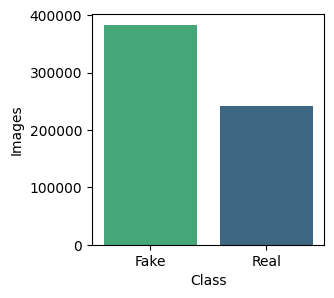

In [4]:
plt.figure(figsize=(3, 3))
column_order = df['target'].value_counts().index
sns.countplot(x=df['target'], hue=df['target'], order=column_order, palette='viridis')
plt.xlabel('Class')
plt.ylabel('Images')
plt.show()

### Split data into training, validation, and test dataframes

In [36]:
def split_df(df):
    # Training dataframe
    train_df, dummy_df = train_test_split(
        df, train_size=0.8, shuffle=True, random_state=RANDOM_STATE)

    # Validation and Test dataframes
    valid_df, test_df = train_test_split(
        dummy_df, train_size=0.6, shuffle=True, random_state=RANDOM_STATE)
    
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_df(df)

### Display data distribution across sets

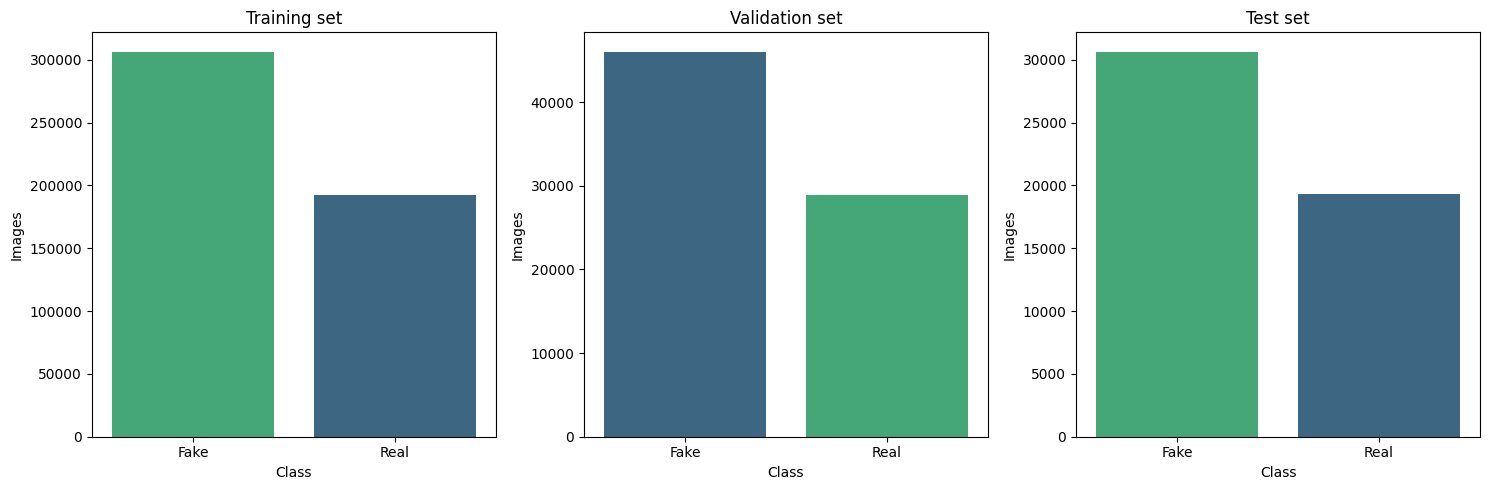

In [6]:
# Create subplots in a horizontal grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plots
dfs = {'Training set': train_df, 'Validation set': valid_df, 'Test set': test_df}
for idx, (key, value) in enumerate(dfs.items()):
    column_order = value['target'].value_counts().index
    sns.countplot(x=value['target'], hue=value['target'], ax=axes[idx],
                  order=column_order, palette='viridis')
    axes[idx].set_title(key)
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Images')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Data ingestion

### Create image data generators for lazy loading

In [37]:
def create_data_generators(train_df, valid_df, test_df):
    # Recommended: use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1,
                        ts_length + 1) if ts_length % n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function can be used for data augmentation. In this case, we just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function=scalar)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col='target', target_size=IMG_SIZE, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image_path', y_col='target', target_size=IMG_SIZE, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE)

    # Note: we will use custom test_batch_size, and make shuffle=false
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image_path', y_col='target', target_size=IMG_SIZE, class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen

train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df)

### Display training data samples

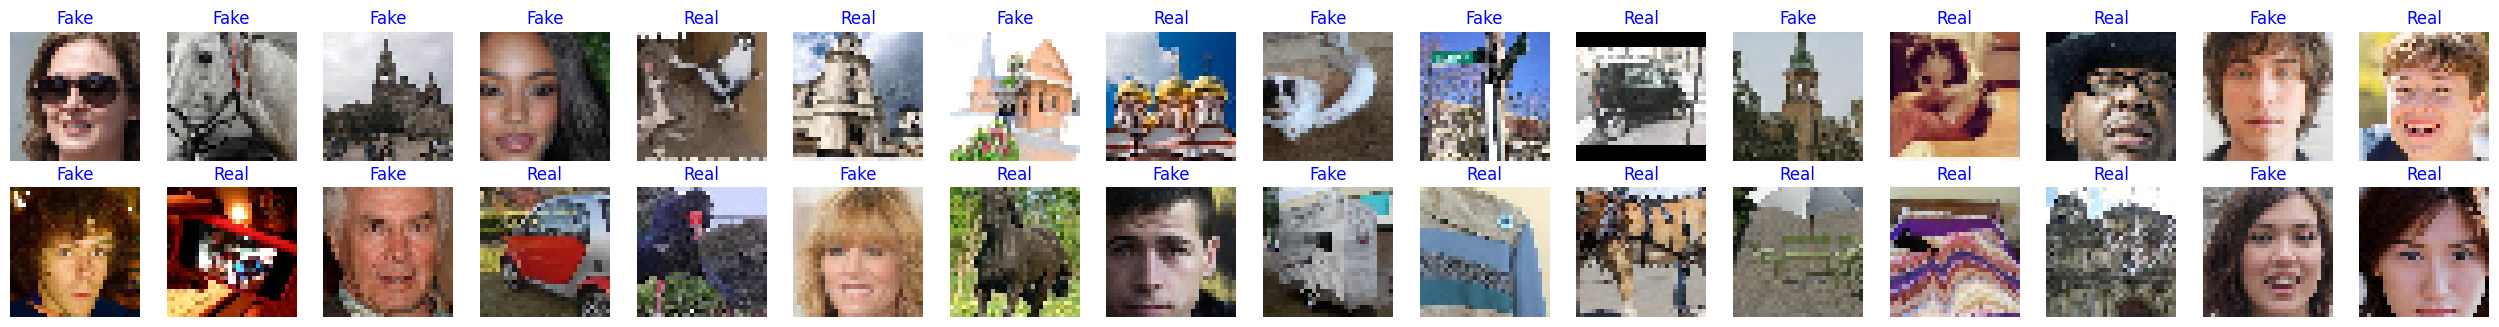

In [30]:
g_dict = train_gen.class_indices    # defines dictionary {'class': index}
# defines list of dictionary's kays (classes), classes names : string
classes = list(g_dict.keys())
# get a batch size samples from the generator
images, labels = next(train_gen)

plt.figure(figsize=IMG_SIZE)

for i in range(BATCH_SIZE):
    plt.subplot(math.ceil(BATCH_SIZE/2), math.ceil(BATCH_SIZE/2), i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

# Modeling

### Define the model

In [31]:
# Define the model
def build_model(hp):
    # DYNAMIC HYPERPARAMETERS

    # Batch nmormalization layer
    momentum = hp.Float('momentum', min_value=0.9, max_value=0.99)
    epsilon = hp.Float('epsilon', min_value=1e-8,
                       max_value=1e-3, sampling='log')
    # Dense 1 layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    l1_regularizer = hp.Float('l1_regularizer', min_value=1e-5, max_value=1e-2)
    l2_regularizer = hp.Float('l2_regularizer', min_value=1e-5, max_value=1e-2)
    # Dropout
    dropout_rate = hp.Float('dropput', min_value=0.2, max_value=0.5)
    # Dense 2 layer
    class_count = len(list(train_gen.class_indices.keys()))
    # Learning rate
    learning_rate = hp.Float(
        'learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # MODEL

    # Transfer learning from an EfficientNet pre-trained model.
    base_model = EfficientNetB0(
        include_top=False, weights="imagenet", input_shape=IMG_SHAPE, pooling='max')

    model = Sequential([
        base_model,
        # Batch normalization applies a transformation that maintains
        # the mean output close to 0 and the output standard deviation close to 1
        BatchNormalization(axis=-1, momentum=momentum, epsilon=epsilon),
        Dense(units=dense_units,
              kernel_regularizer=regularizers.l2(l=l2_regularizer),
              activity_regularizer=regularizers.l1(l1_regularizer),
              bias_regularizer=regularizers.l1(l1_regularizer),
              activation='relu'),
        Dropout(rate=dropout_rate, seed=RANDOM_STATE),
        Dense(class_count, activation='softmax')
    ])

    model.compile(Adamax(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### Perform hyperparameter tuning via Bayesian Optimization

In [32]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    overwrite=True,
    directory=LOGS_DIR + '/tuner/',
    project_name='picazo_hypermodel_tuning_lenet_5',
)

tensorboard_logs = LOGS_DIR + '/tensorboard/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tuner.search(train_gen,
             validation_data=valid_gen,
             epochs=EPOCHS,
             callbacks=[EarlyStopping(monitor='val_loss', patience=2),
                        TensorBoard(log_dir=tensorboard_logs, histogram_freq=1)])  # Early stopping to prevent overfitting)

Trial 10 Complete [00h 37m 25s]
val_accuracy: 0.6844677329063416

Best val_accuracy So Far: 0.706977128982544
Total elapsed time: 06h 43m 25s


### Display best model results

In [33]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best Hyperparameters: {best_hps.values}')

# Build the final model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
print('Best model: ')
best_model.summary()

Best Hyperparameters: {'momentum': 0.9566911405505518, 'epsilon': 0.0003479912825359492, 'dense_units': 160, 'l1_regularizer': 0.001163793139910865, 'l2_regularizer': 0.002482534022611746, 'dropput': 0.23015942950819798, 'learning_rate': 0.0006588156968074904}
Best model: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 160)               204960    
                                                                 
 dropout_1 (Dropout)         (None, 160)    

### Save the model for future use

In [34]:
best_model.save(MODEL_BACKUP)

## Re-training

### Re-training best model (that with best hyperparameters) on full dataset

In [42]:
# Recover model with best hyperparameters from disk
print('Loading best model...')
best_model = load_model(MODEL_BACKUP)
best_model.summary()

# Load full dataset
print('Indexing and spliting data...')
df = df_from_csv_files(DATASET)
train_df, valid_df, test_df = split_df(df)
print(f'Train df: {train_df.shape}\n'
      f'Valid df: {valid_df.shape}\n'
      f'Test df: {test_df.shape}')

# Data generators
print('Initializing lazy data loaders..')
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df)

# Let's train for 10 epochs with best model (time to go to sleep :D)
print('Ready, steady, train!')
history = best_model.fit(train_gen, validation_data=valid_gen, epochs=10)

Loading best model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 160)               204960    
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 322       
                                                                 
Total params: 4259973 (16.25 MB)

In [44]:
best_model.save(MODEL_BACKUP)

### Training history

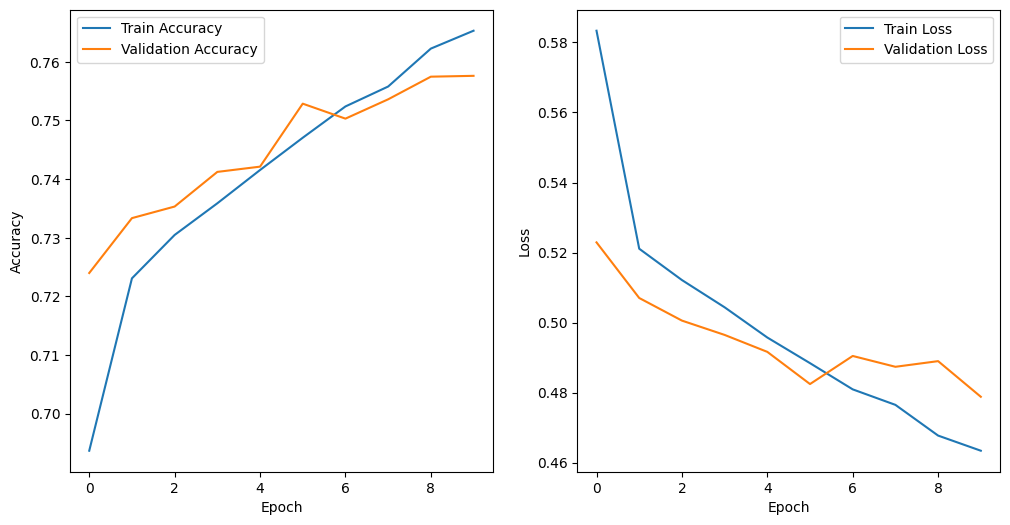

In [45]:
# Plot training history (train accuracy vs validation accuracy and train loss vs validation loss)
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot training history
plot_training_history(history)

## Performance evaluation
Metrics evaluation over the test dataset.

#### Loss and accuracy

In [46]:
test_loss, test_accuracy = best_model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy}. Test Loss: {test_loss}')

3329/3329 [==============================] - 550s 165ms/step - loss: 0.4789 - accuracy: 0.7583
Test Accuracy: 0.7583158016204834. Test Loss: 0.47887128591537476


#### Confusion matrix

3329/3329 [==============================] - 526s 158ms/step


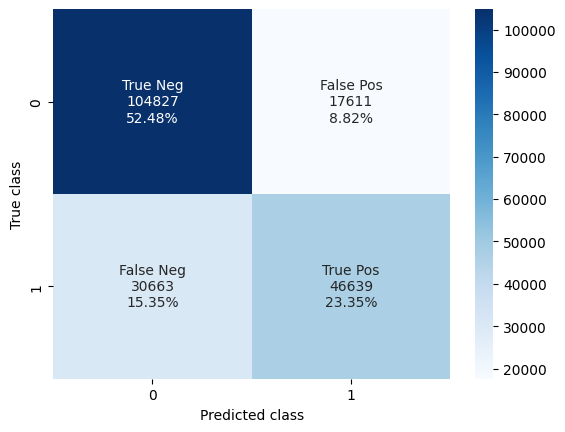

In [47]:
def plot_confusion_matrix(conf_matrix):
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.show()


probabilities = best_model.predict(test_gen)
y_pred = [np.argmax(prob) for prob in probabilities]
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm)

#### Classification report

In [48]:
class_report = classification_report(y_true, y_pred)

print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81    122438
           1       0.73      0.60      0.66     77302

    accuracy                           0.76    199740
   macro avg       0.75      0.73      0.74    199740
weighted avg       0.76      0.76      0.75    199740

